In [1]:
# Librerías
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# Librerías de configuración
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# Librerías de métricas de evaluación
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Librerías de modelos y algoritmos
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
# Librerías de modelos de aprendizaje profundo
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor
# Librerías de modelos estadísticos
import statsmodels.api as sm
# Librerías para guardar modelos
from pickle import dump
from pickle import load
# Librerías de modelos de series temporales
from statsmodels.tsa.arima_model import ARIMA
# Librerías de métricas de error
from sklearn.metrics import mean_squared_error
# Librerías de selección de características
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
# Librerías de visualización
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf
# Deshabilitar warnings
import warnings
warnings.filterwarnings('ignore')


2024-06-13 10:39:30.292726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Cargando los datos

In [8]:
# Obtener los datos por webscrapping usando pandas_datareader
tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               'TREAST', 'FYGFDPUN', 'FDHBFIN', 'GFDEBTN', 'BAA10Y']
tsy_data = web.DataReader(tsy_tickers, 'fred', start='1/1/2010').dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOV_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOM_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOR_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

In [9]:
return_period = 5
Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]
X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']]
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]
dataset

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2010-01-06,0.02,2.55,4.71,0.03,0.06,0.40,1.01,2.60,3.33,3.85,4.70,0.060799,0.649352,0.303598,2.49
2010-01-13,0.02,2.38,4.50,0.02,0.06,0.37,0.97,2.55,3.28,3.80,4.71,0.060800,0.649352,0.303598,2.50
2010-01-21,0.01,2.41,4.57,0.02,0.06,0.31,0.87,2.38,3.09,3.62,4.50,0.060800,0.649352,0.303598,2.51
2010-01-28,0.04,2.29,4.53,0.01,0.08,0.31,0.87,2.41,3.15,3.68,4.57,0.060801,0.649352,0.303598,2.57
2010-02-04,0.05,2.39,4.69,0.04,0.09,0.32,0.80,2.29,3.06,3.62,4.53,0.060801,0.649352,0.303598,2.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-06,5.50,4.50,4.63,5.51,5.45,5.12,4.82,4.48,4.48,4.49,4.64,0.130626,0.796073,0.233958,1.47
2024-05-13,5.50,4.46,4.58,5.50,5.45,5.16,4.85,4.50,4.49,4.48,4.63,0.130649,0.796073,0.233958,1.48
2024-05-20,5.50,4.56,4.66,5.50,5.45,5.15,4.82,4.46,4.44,4.44,4.58,0.129764,0.796073,0.233958,1.47


### Análisis exploratorio de datos

In [10]:
# Estadística descriptiva
print(dataset.shape)
print(dataset.describe())

(729, 15)
       DGS1MO_pred   DGS5_pred  DGS30_pred      DGS1MO      DGS3MO  \
count   729.000000  729.000000  729.000000  729.000000  729.000000   
mean      1.048738    1.858532    3.091084    1.041289    1.103978   
std       1.643399    1.075428    0.822082    1.635665    1.668927   
min       0.000000    0.210000    1.200000    0.000000    0.000000   
25%       0.040000    1.110000    2.600000    0.040000    0.050000   
50%       0.130000    1.640000    3.020000    0.130000    0.150000   
75%       1.610000    2.400000    3.660000    1.600000    1.700000   
max       5.730000    4.810000    5.040000    5.730000    5.630000   

             DGS1        DGS2        DGS5        DGS7       DGS10       DGS30  \
count  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000   
mean     1.247174    1.376447    1.856049    2.164979    2.434047    3.091317   
std      1.595863    1.413077    1.071612    0.964088    0.888813    0.822515   
min      0.040000    0.090000    0.

<Axes: xlabel='DATE'>

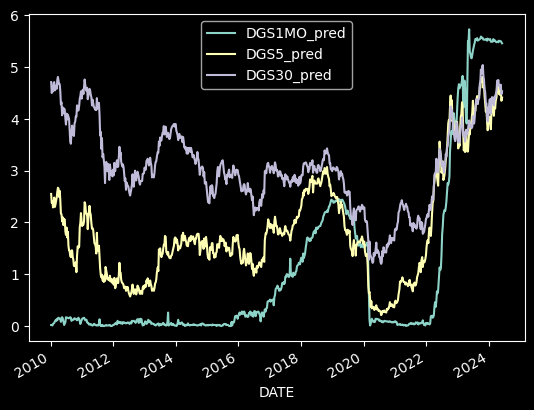

In [11]:
# Visualización de datos
Y.plot()

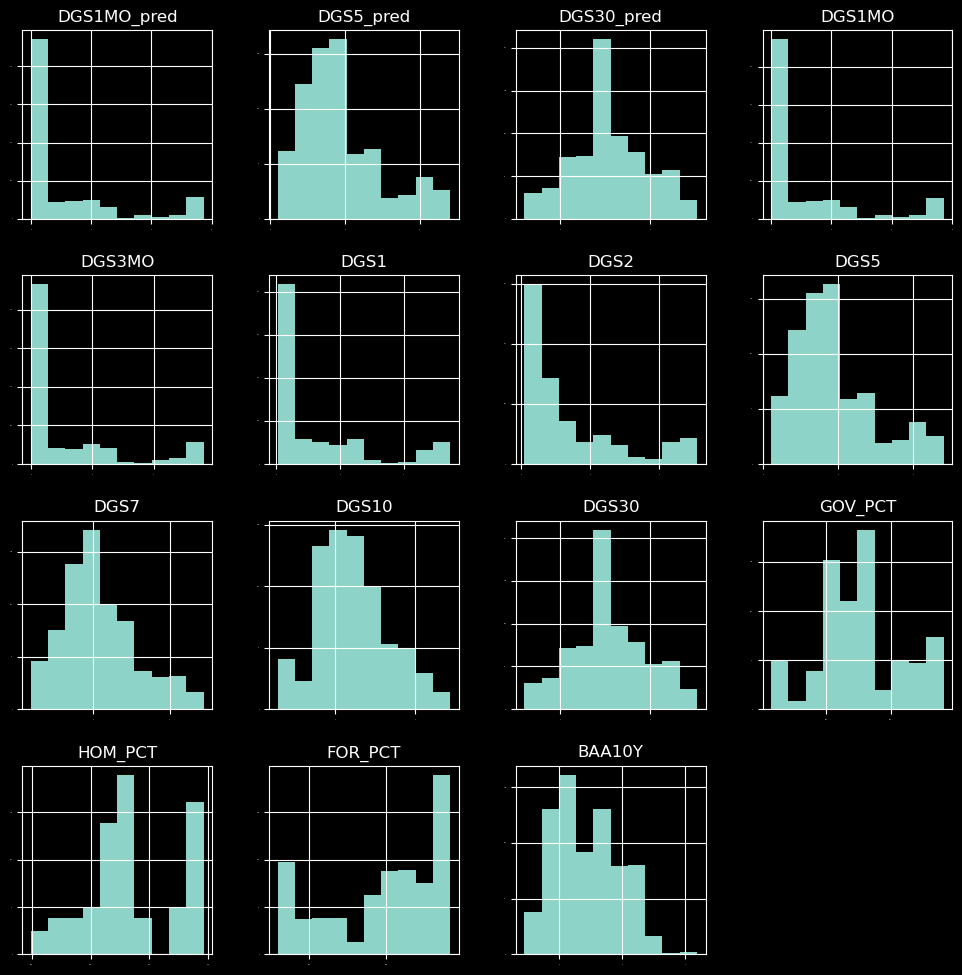

In [12]:
# histograma
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12, 12))
pyplot.show()

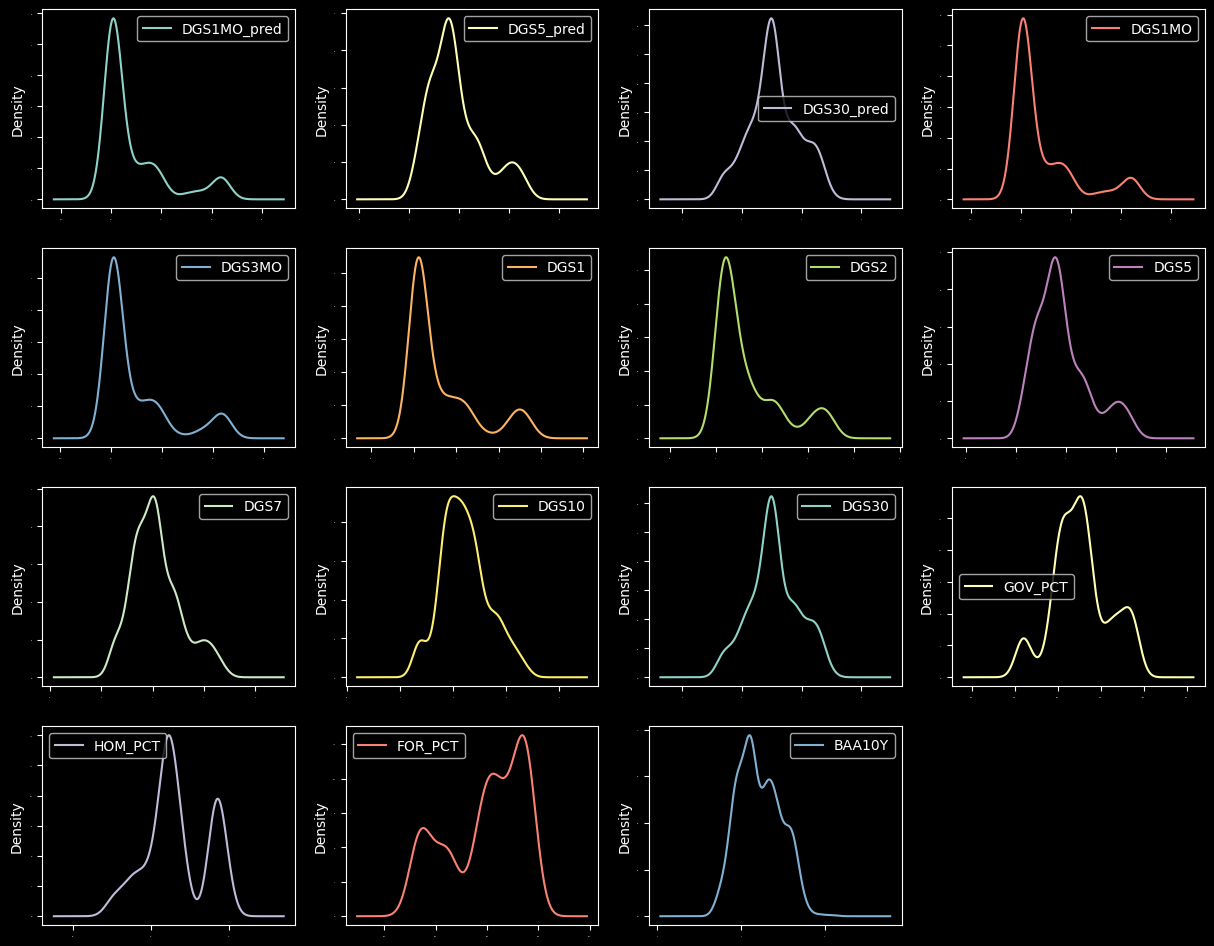

In [13]:
# densidad
dataset.plot(kind='density', subplots=True, layout=(5, 4), sharex=False, legend=True, fontsize=1, figsize=(15, 15))
pyplot.show()

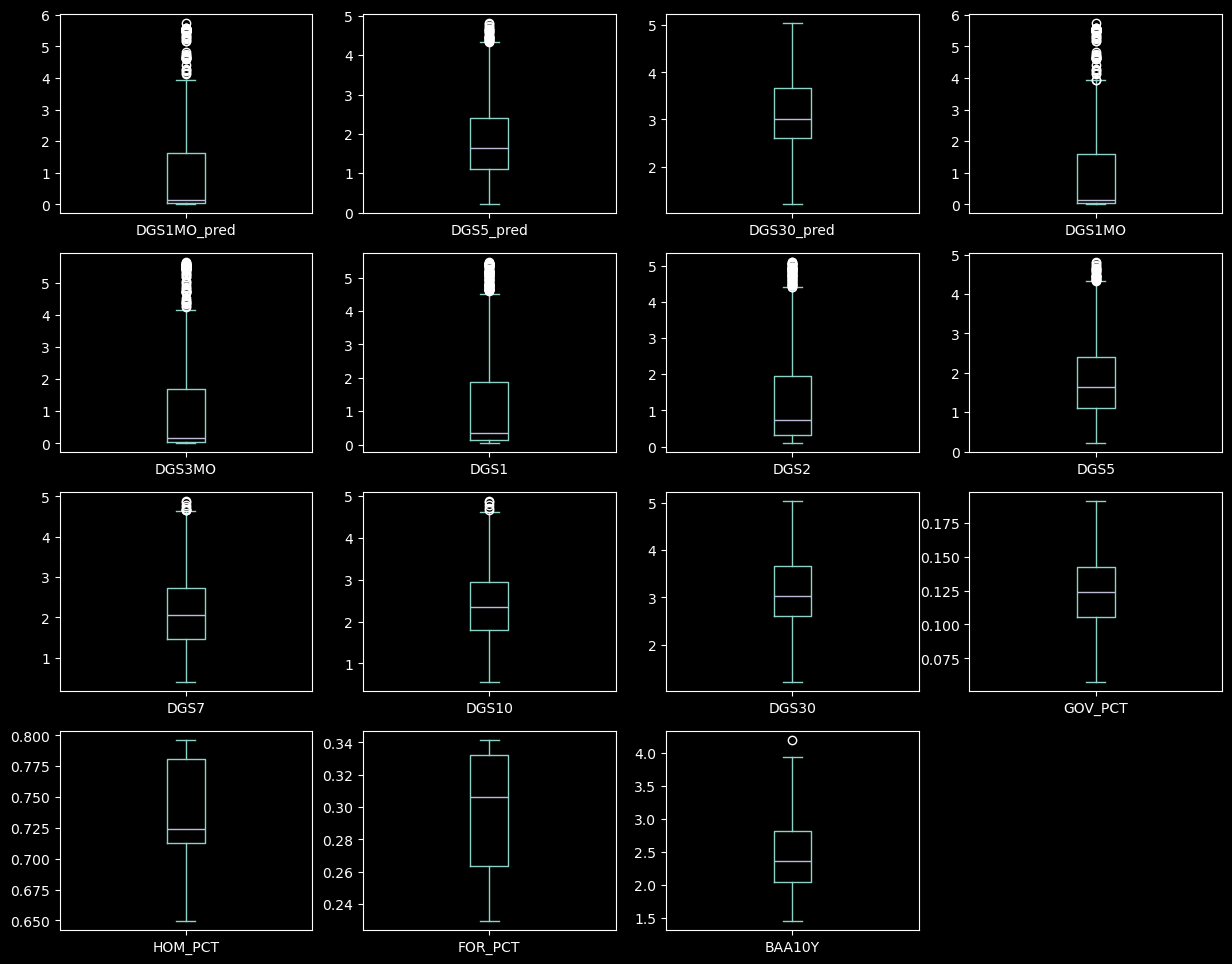

In [14]:
# Boxplot
dataset.plot(kind='box', subplots=True, layout=(5, 4), sharex=False, sharey=False, figsize=(15, 15))
pyplot.show()

<Axes: title={'center': 'Correlation Matrix'}>

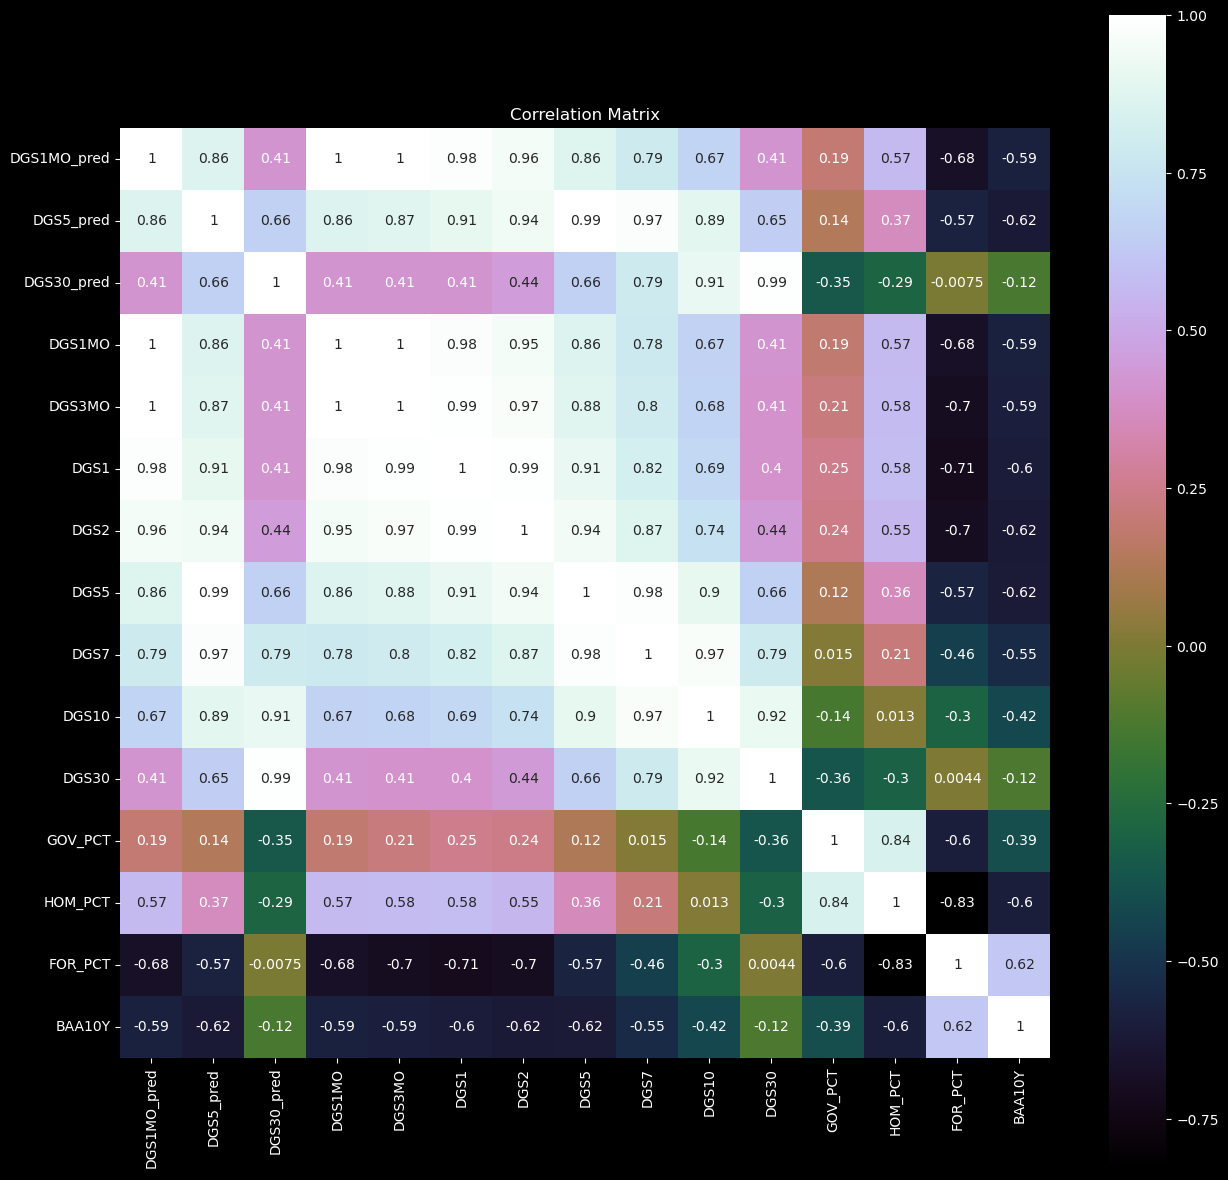

In [15]:
# Correlación
correlation = dataset.corr()
pyplot.figure(figsize=(15, 15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

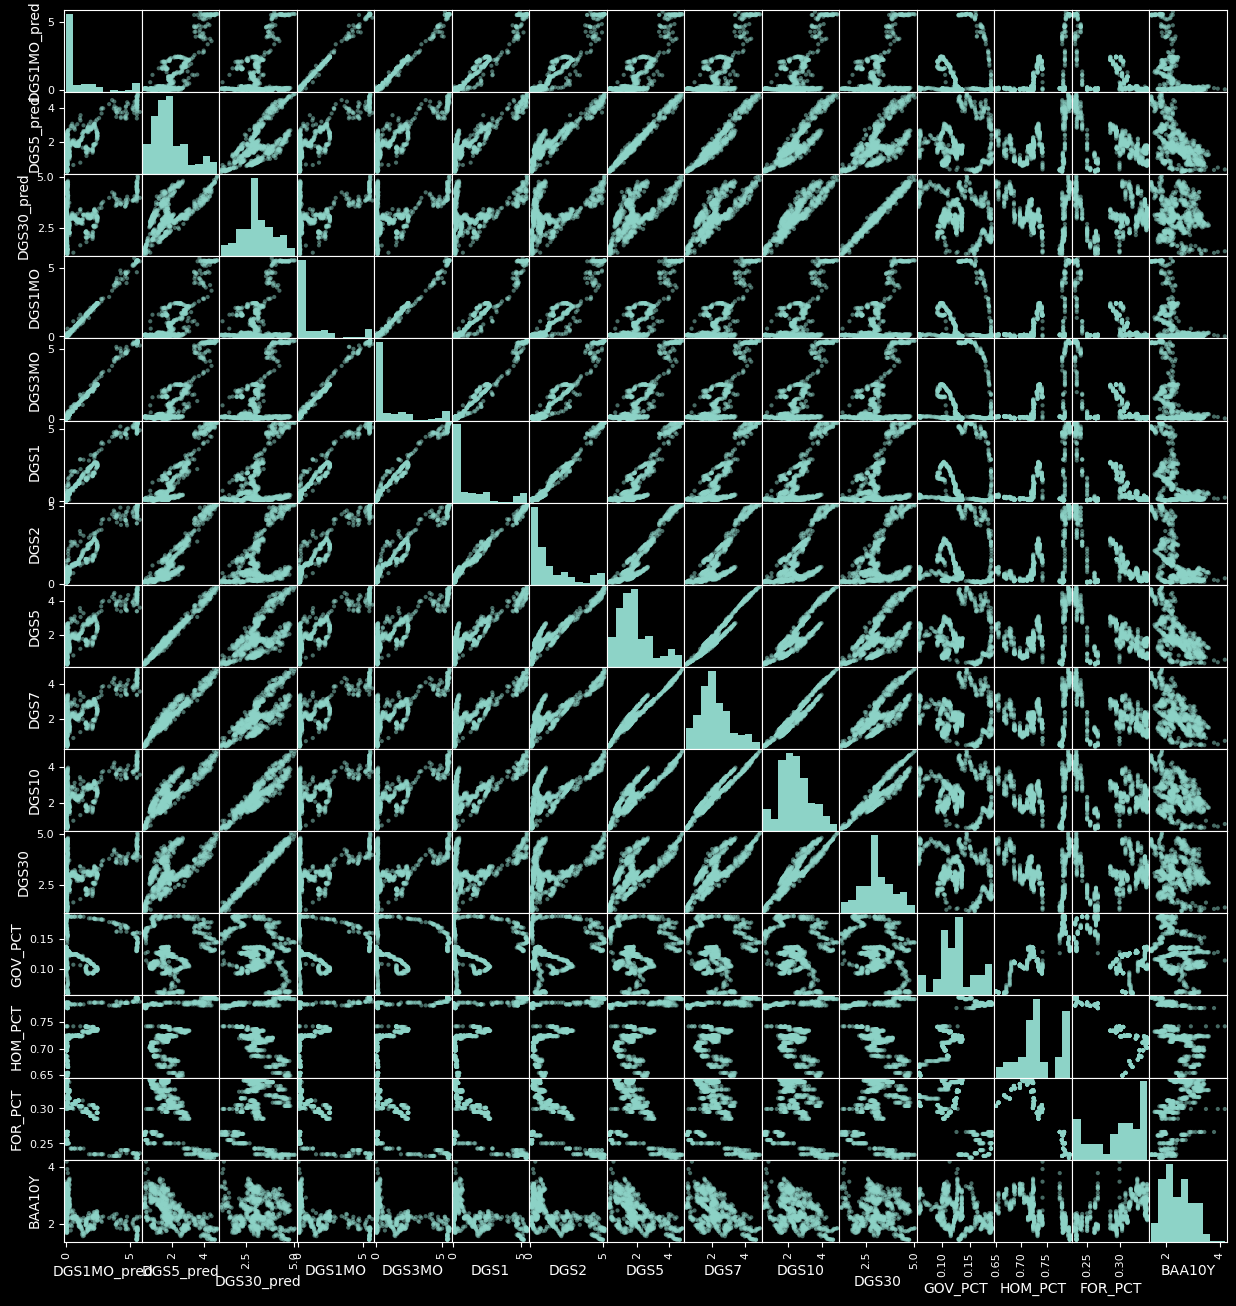

In [16]:
# Scatterplot Matrix
pyplot.figure(figsize=(15, 15))
scatter_matrix(dataset, figsize=(15, 16))
pyplot.show()

### Análisis de las series temporales

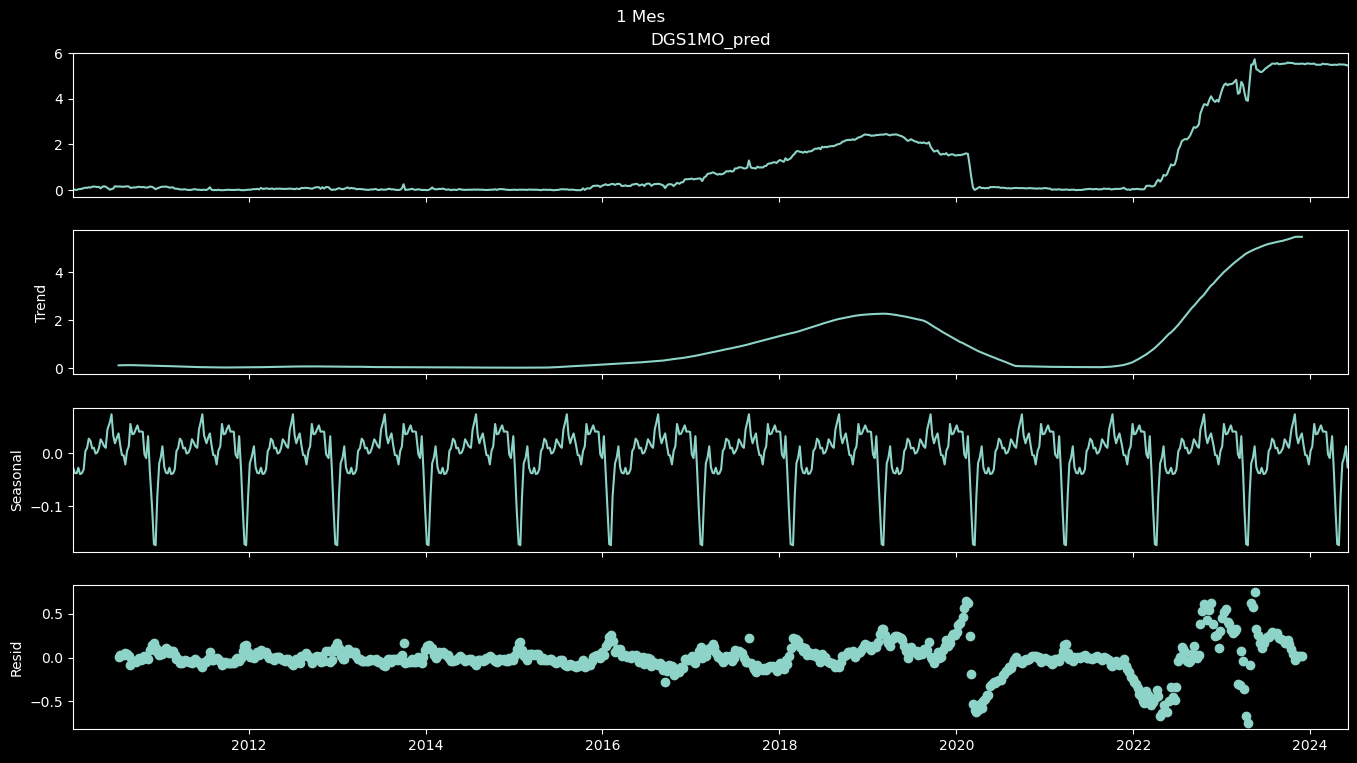

In [18]:
res = sm.tsa.seasonal_decompose(dataset['DGS1MO_pred'], period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
fig.suptitle('1 Mes')
pyplot.show()

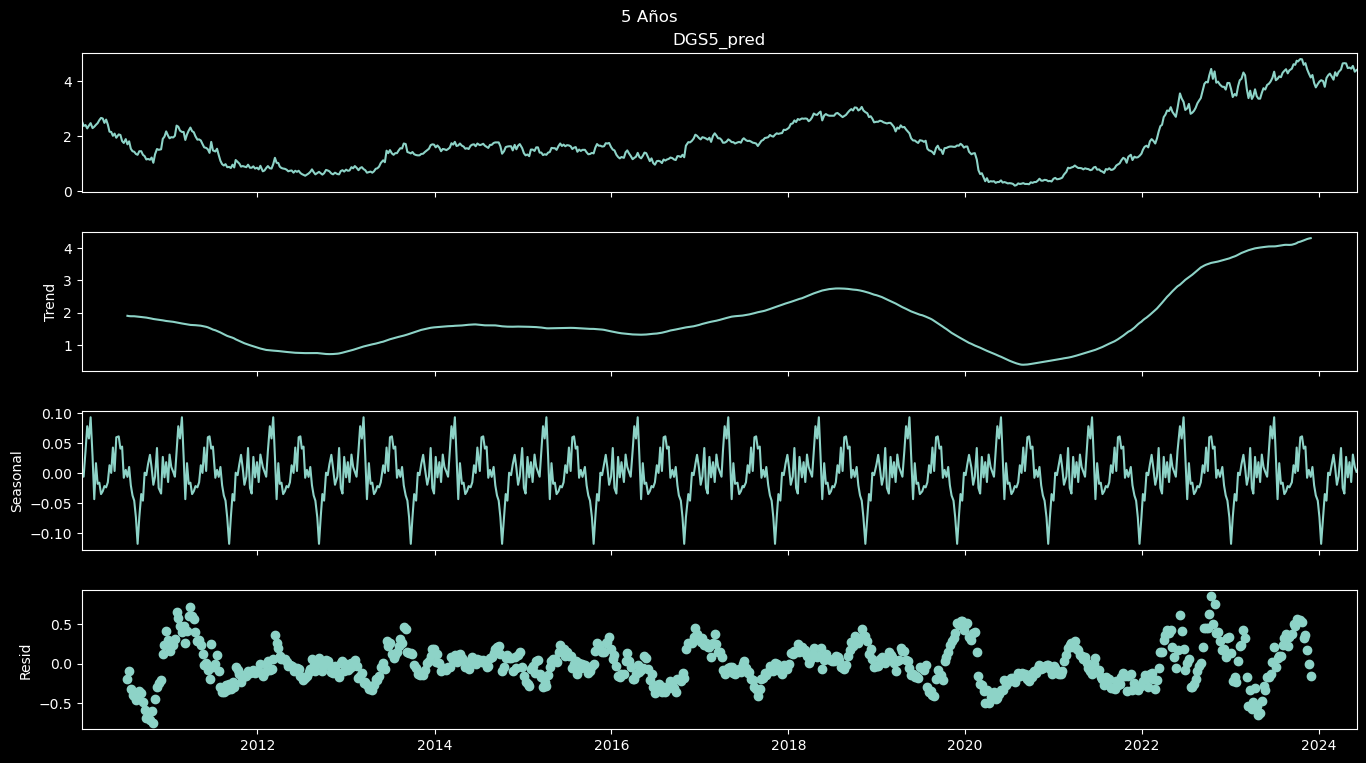

In [19]:
res = sm.tsa.seasonal_decompose(dataset['DGS5_pred'], period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
fig.suptitle('5 Años')
pyplot.show()

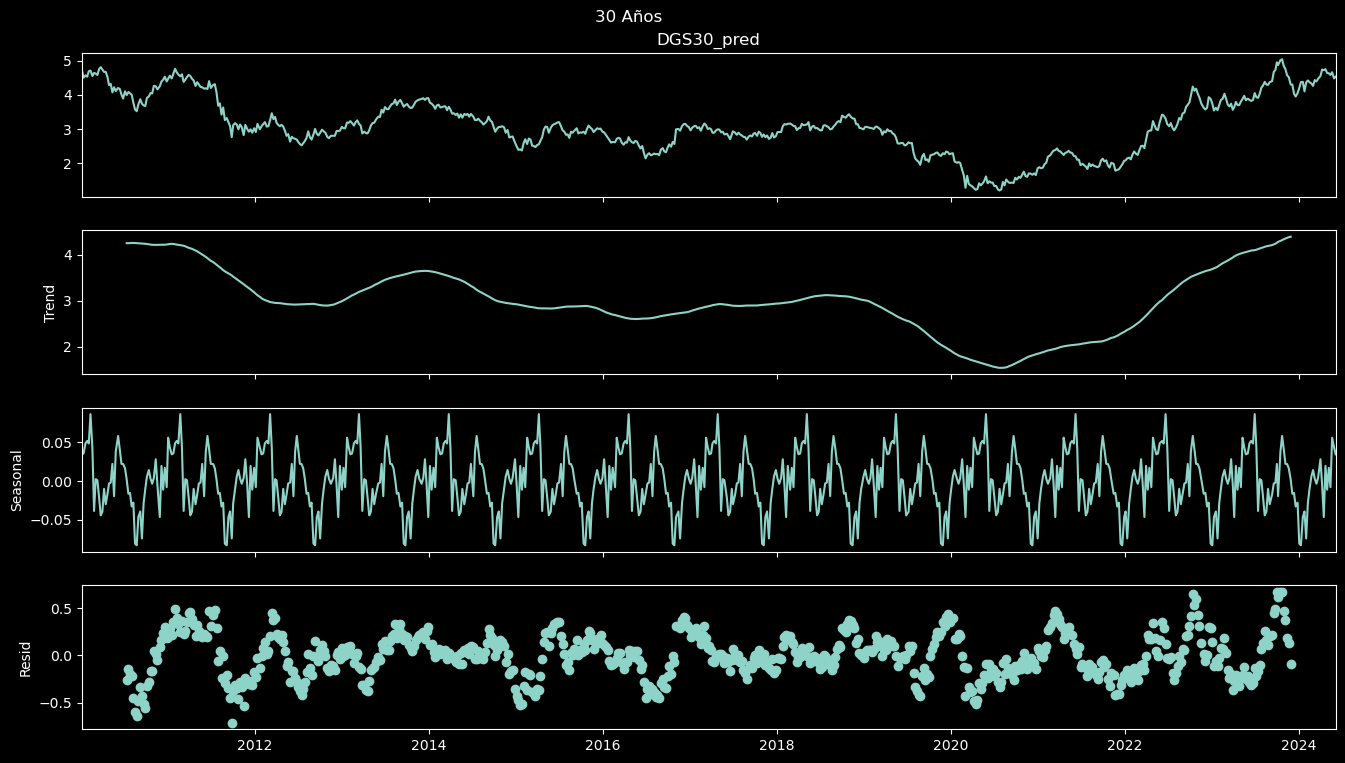

In [20]:
res = sm.tsa.seasonal_decompose(dataset['DGS30_pred'], period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
fig.suptitle('30 Años')
pyplot.show()

### Preparación de los datos

In [21]:
# Selección de características univariada
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X, temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = pd.concat([dfcolumns, dfscores], axis=1)
    featureScores.columns = ['Specs', 'Score']
    print(col)
    print(featureScores.nlargest(10, 'Score'))
    print('______________________')

DGS1MO_pred
      Specs          Score
0    DGS1MO  264605.026800
1    DGS3MO  127223.439701
2      DGS1   17205.685712
3      DGS2    7547.211962
4      DGS5    2156.031549
5      DGS7    1185.156547
10  FOR_PCT     629.171813
6     DGS10     599.434533
11   BAA10Y     382.991050
9   HOM_PCT     346.369910
______________________
DGS5_pred
      Specs         Score
4      DGS5  60391.648236
5      DGS7  12284.965847
3      DGS2   5686.891128
2      DGS1   3364.020786
6     DGS10   2843.035623
1    DGS3MO   2326.336961
0    DGS1MO   2023.023027
7     DGS30    528.216164
11   BAA10Y    447.152070
10  FOR_PCT    359.030598
______________________
DGS30_pred
     Specs         Score
7    DGS30  40908.643161
6    DGS10   3519.863317
5     DGS7   1183.396073
4     DGS5    553.105749
3     DGS2    179.289645
0   DGS1MO    146.231051
2     DGS1    146.042824
1   DGS3MO    145.943568
8  GOV_PCT    102.384186
9  HOM_PCT     68.393088
______________________


### Modelos y algoritmos

In [37]:
# Train y test
validation_size = 0.2
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)
# Métricas de error
num_folds = 10
scoring = 'neg_mean_squared_error'

In [24]:
# Lista de modelos
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('MLP', MLPRegressor()))

In [25]:
# Entrenamiento de modelos
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    # convierto el error a negativo, el menor es el mejor
    kfold = KFold(n_splits=num_folds)
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)
    # Entrenamiento y validación del modelo
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    train_results.append(train_result)
    # print resultados
    msg = f"""{name}: 
            \nAverage CV Error: {cv_results.mean()}
            \nStd CV Error: {cv_results.std()}
            \nTraining Error: {train_result}
            \nTest Error: {validation_result}
            """
    print(msg)
    print('------------------------')

LR: 
            
Average CV Error: 0.010808582913006539
            
Std CV Error: 0.002420634564730951
            
Training Error: 0.010008945246371961
            
Test Error: 0.010767118887159801
            
------------------------
LASSO: 
            
Average CV Error: 0.546295742636051
            
Std CV Error: 0.09278783482650776
            
Training Error: 0.5398250546299214
            
Test Error: 0.5516524013027452
            
------------------------
EN: 
            
Average CV Error: 0.31320834605828984
            
Std CV Error: 0.04798061517803672
            
Training Error: 0.309067007219238
            
Test Error: 0.3262312656495643
            
------------------------
KNN: 
            
Average CV Error: 0.013055240755893238
            
Std CV Error: 0.003856821361467743
            
Training Error: 0.008285344768439106
            
Test Error: 0.015830557077625575
            
------------------------
CART: 
            
Average CV Error: 0.027039278199883

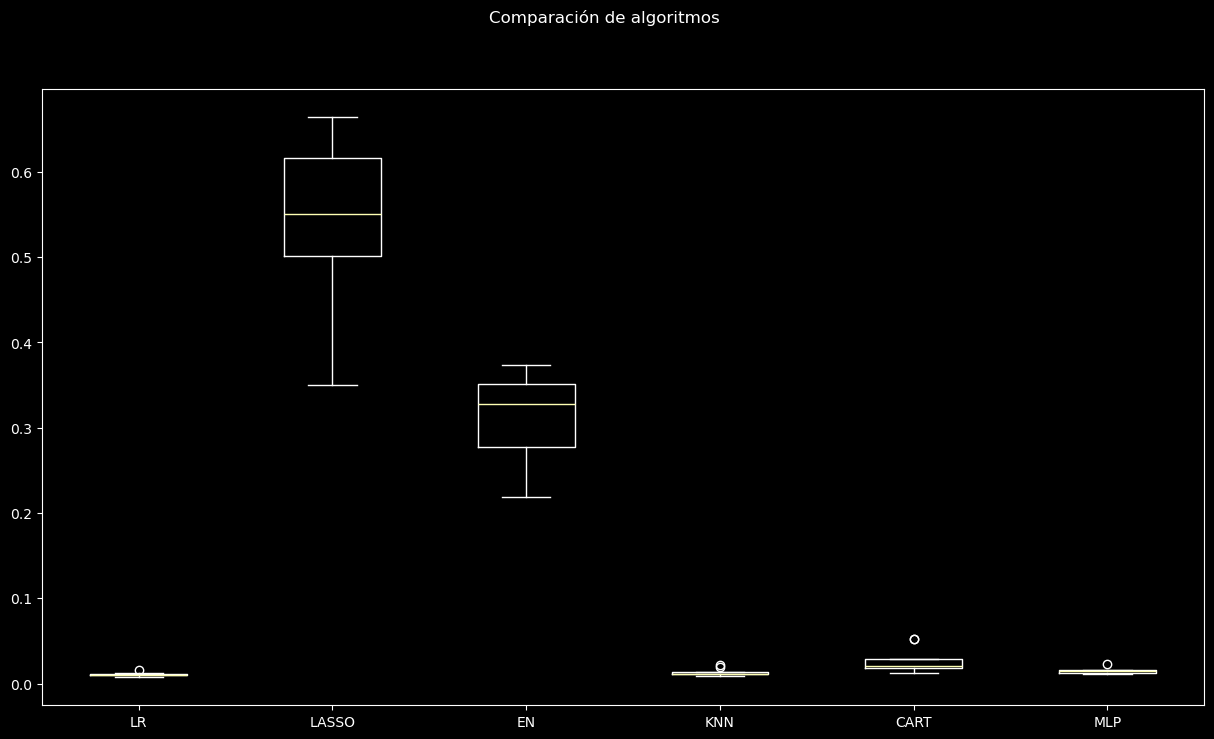

In [26]:
# visualización comparativa de algoritmos
fig = pyplot.figure()
fig.suptitle('Comparación de algoritmos')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
pyplot.show()

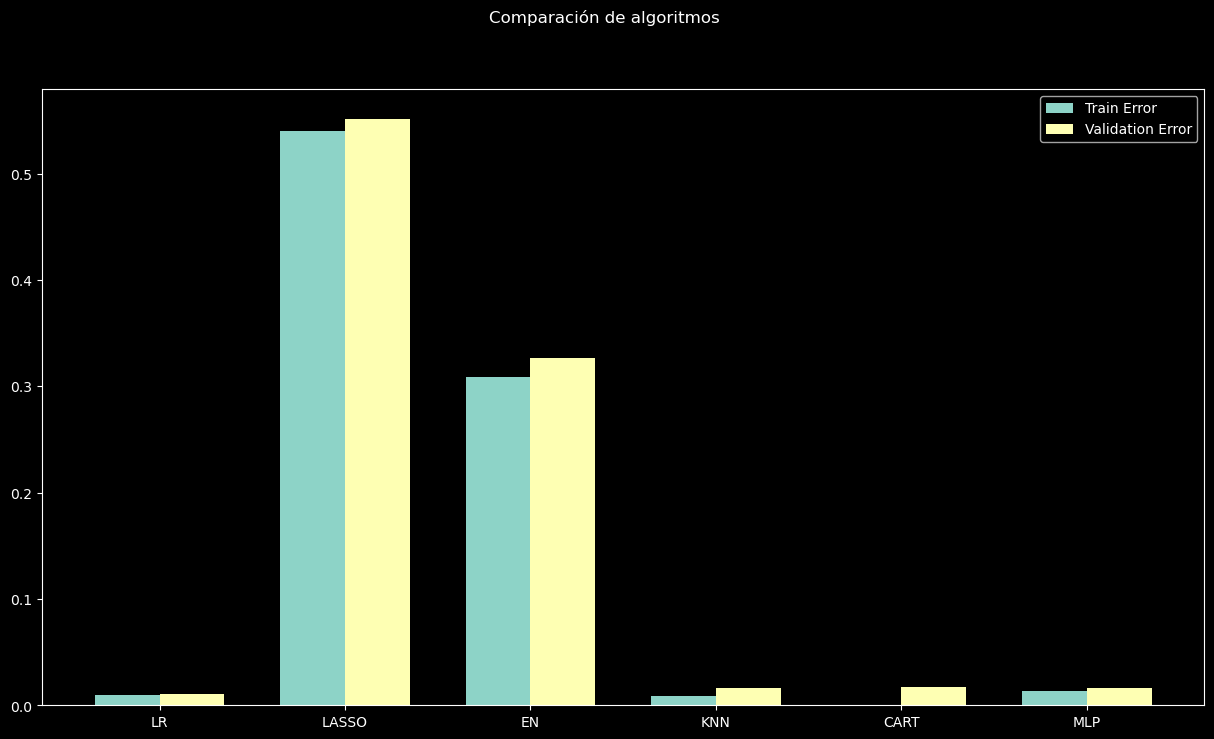

In [27]:
fig = pyplot.figure()
ind = np.arange(len(names))
width = 0.35
fig.suptitle('Comparación de algoritmos')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, [x.mean() for x in train_results], width=width, label='Train Error')
pyplot.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15, 8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

### Tuning de modelos y Grid Search

In [28]:
# Grid seach : MLPRegressor
param_grid = {'hidden_layer_sizes': [(20,), (50,), (20, 20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print(f"{mean} ({std}) with: {param}")

Best: -0.01695921413685089 using {'hidden_layer_sizes': (20, 30, 20)}
-0.03616835613321049 (0.016967121607437467) with: {'hidden_layer_sizes': (20,)}
-0.018339763583015922 (0.005469887588411766) with: {'hidden_layer_sizes': (50,)}
-0.020979428412153413 (0.0052740180461875435) with: {'hidden_layer_sizes': (20, 20)}
-0.01695921413685089 (0.0032789118722939665) with: {'hidden_layer_sizes': (20, 30, 20)}


### Finalizar el modelo

In [33]:
model = MLPRegressor(hidden_layer_sizes=grid_result.best_params_['hidden_layer_sizes'])
model.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

### Resultados y comparación de los modelos

In [35]:
# modelo mlp
predictions = model.predict(X_validation)
mse_MLP = mean_squared_error(Y_validation, predictions)
r2_MLP = r2_score(Y_validation, predictions)
# modelo linear regression
model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_validation)
mse_LR = mean_squared_error(Y_validation, predictions_2)
r2_LR = r2_score(Y_validation, predictions_2)
print(f"MSE LR = {mse_LR}, MSE MLP = {mse_MLP}")
print(f"R2 LR = {r2_LR}, R2 MLP = {r2_MLP}")

MSE LR = 0.010767118887159798, MSE MLP = 0.016035678566434564
R2 LR = 0.989327170035983, R2 MLP = 0.9835767263233018


### Comparación de predicciones a 5 años

In [38]:
train_size = int(len(X) * (1 - validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes=(50,))
modelLR = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_LR = modelLR.fit(X_train, Y_train)

Y_pred_MLP = pd.DataFrame(model_MLP.predict(X_validation), index=Y_validation.index,
                          columns=Y_validation.columns)
Y_pred_LR = pd.DataFrame(model_LR.predict(X_validation), index=Y_validation.index,
                         columns=Y_validation.columns)

<Axes: xlabel='DATE'>

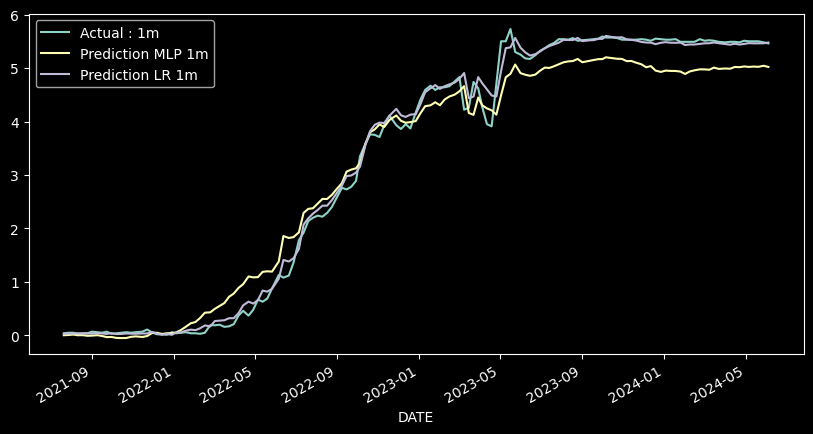

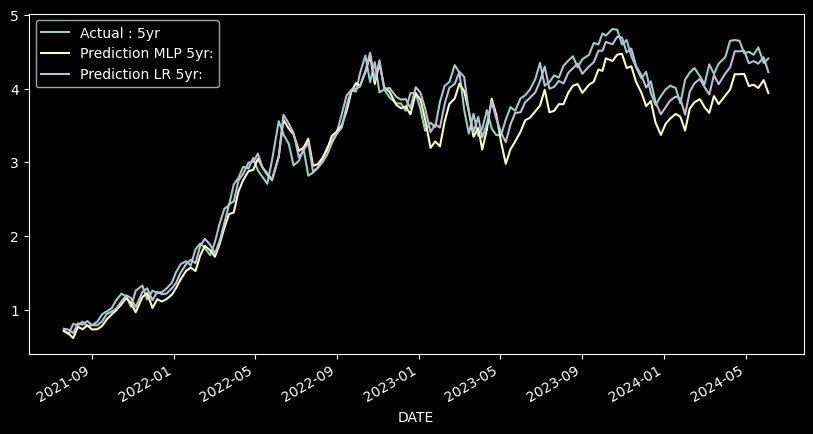

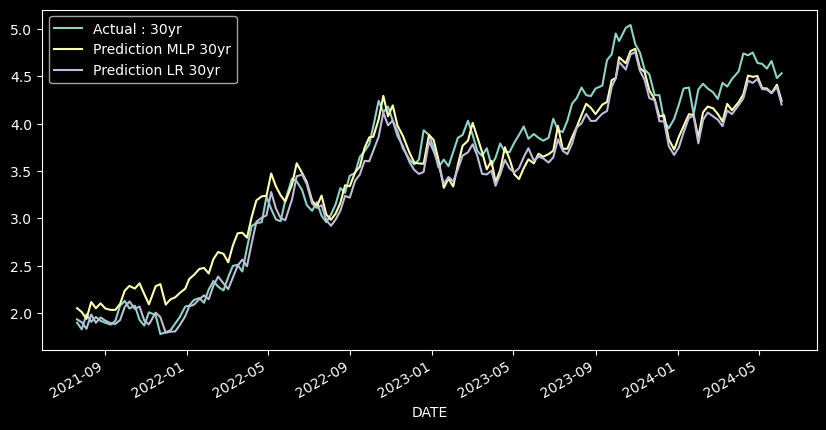

In [39]:
pd.DataFrame({'Actual : 1m': Y_validation.loc[:, 'DGS1MO_pred'],
             'Prediction MLP 1m': Y_pred_MLP.loc[:, 'DGS1MO_pred'],
             'Prediction LR 1m': Y_pred_LR.loc[:, 'DGS1MO_pred']}).plot(figsize=(10, 5))
pd.DataFrame({'Actual : 5yr': Y_validation.loc[:, 'DGS5_pred'],
              'Prediction MLP 5yr:': Y_pred_MLP.loc[:, 'DGS5_pred'],
              'Prediction LR 5yr:': Y_pred_LR.loc[:, 'DGS5_pred']}).plot(figsize=(10, 5))
pd.DataFrame({'Actual : 30yr': Y_validation.loc[:, 'DGS30_pred'],
              'Prediction MLP 30yr': Y_pred_MLP.loc[:, 'DGS30_pred'],
              'Prediction LR 30yr': Y_pred_LR.loc[:, 'DGS30_pred']}).plot(figsize=(10, 5))